In [1]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_community.llms import LlamaCpp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score
import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [2]:
retrieval_strategy = "mmr"
model = "llama-2-7b-chat.Q4_K_M"

persist_directory = "./../embeddings"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [4]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        # self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        # self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses

    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [5]:
with open(f"{persist_directory}/embeddings.pickle", "rb") as handle:
    embeddings = pickle.load(handle)

In [6]:
vectordb = Chroma(
    "documents",  # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [7]:
retriever = vectordb.as_retriever(
    search_type=f"{retrieval_strategy}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [8]:
llm_open = LlamaCpp(
    model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    n_ctx=4096,  # 4096 for Llama, 32*1024 for Mistral
    n_gpu_layers=50,
    temperature=0.15,
    top_p=1,
    top_k=40,
    repeat_penalty=1.1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    stream=True,
)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! stream is not default parameter.
                stream was transferred to model_kwargs.
                Please confirm that stream is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/arnewman/.cache/lm-studio/models/TheBloke/Llama-2-7B-Chat-GGUF/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader

In [15]:
from langchain_core.prompts import PromptTemplate

template = """
Use only the following pieces of context to answer the question at the end. 
Keep your answers concise and do not provide additional explanations. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:
"""

In [16]:
qa_chain = RetrievalQA.from_chain_type(
    # qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template, input_variables=["context", "question"]
        )
    },
)

In [17]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)


Use only the following pieces of context to answer the question at the end. 
Keep your answers concise and do not provide additional explanations. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:



In [18]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...
Data Mining II (SIADS 632) involves time series analysis.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       1.81 ms /    19 runs   (    0.10 ms per token, 10468.32 tokens per second)
llama_print_timings: prompt eval time =   22170.42 ms /   916 tokens (   24.20 ms per token,    41.32 tokens per second)
llama_print_timings:        eval time =     679.07 ms /    18 runs   (   37.73 ms per token,    26.51 tokens per second)
llama_print_timings:       total time =   23028.44 ms /   934 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Data Mining II (SIADS 632): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Communicating Data Science Results (SIADS 523): Course Schedule


## Run the Model

In [19]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [20]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [21]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", "wb") as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "wb") as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


Data Mining II (SIADS 632) involves time series analysis.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       2.12 ms /    19 runs   (    0.11 ms per token,  8962.26 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =    1003.82 ms /    19 runs   (   52.83 ms per token,    18.93 tokens per second)
llama_print_timings:       total time =    1046.72 ms /    20 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Data Mining II (SIADS 632): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Communicating Data Science Results (SIADS 523): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


Graham Hukill (gshukill@umich.edu)


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       1.57 ms /    17 runs   (    0.09 ms per token, 10807.37 tokens per second)
llama_print_timings: prompt eval time =   10630.80 ms /   559 tokens (   19.02 ms per token,    52.58 tokens per second)
llama_print_timings:        eval time =     580.82 ms /    16 runs   (   36.30 ms per token,    27.55 tokens per second)
llama_print_timings:       total time =   11328.91 ms /   575 tokens



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The prerequisites for Data Science for Social Good (SIADS 688) are:
- Preceded or accompanied by SIADS 630, 631, and 694; (C- or better)


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       5.58 ms /    56 runs   (    0.10 ms per token, 10044.84 tokens per second)
llama_print_timings: prompt eval time =   16681.40 ms /   871 tokens (   19.15 ms per token,    52.21 tokens per second)
llama_print_timings:        eval time =    2083.48 ms /    55 runs   (   37.88 ms per token,    26.40 tokens per second)
llama_print_timings:       total time =   19021.88 ms /   926 tokens



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites
3. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
4. Data Science Ethics (SIADS 503): Course Learning Outcomes
5. Data Science for Social Good (SIADS 688): Assignments And Grading You Are Expected To Read An Assigned Paper On Perusall Before Watching Each Lecture, And Complete A Problem Set Afterwards.


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The office hours for Math Methods (SIADS 602) are on Wednesdays from 4:00-5:00 pm EST with Hanna Hoover.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       4.07 ms /    42 runs   (    0.10 ms per token, 10316.88 tokens per second)
llama_print_timings: prompt eval time =   16798.62 ms /   879 tokens (   19.11 ms per token,    52.33 tokens per second)
llama_print_timings:        eval time =    1561.29 ms /    41 runs   (   38.08 ms per token,    26.26 tokens per second)
llama_print_timings:       total time =   18585.23 ms /   920 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Unsupervised Learning (SIADS 543): Office Hours Schedule:
3. Experiment Design and Analysis (SIADS 631): Course Schedule
4. Causal Inference (SIADS 630): Office Hours:
5. Machine Learning Pipelines (SIADS 643): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


No.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       0.29 ms /     3 runs   (    0.10 ms per token, 10489.51 tokens per second)
llama_print_timings: prompt eval time =   14173.83 ms /   742 tokens (   19.10 ms per token,    52.35 tokens per second)
llama_print_timings:        eval time =      74.83 ms /     2 runs   (   37.41 ms per token,    26.73 tokens per second)
llama_print_timings:       total time =   14367.05 ms /   744 tokens



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone II (SIADS 696): Project Component
3. Milestone I (SIADS 593): 6.0 Office Hours
4. Milestone II (SIADS 696): Re-Grade Policy
5. Milestone I (SIADS 593): 7.0 Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


Qualitative Inquiry for Data Scientists (SIADS 601) has the following outcomes:
1. Collect, represent, and analyze qualitative data about a quantitative data set.
2. Develop a narrative about qualitative findings that support later quantitative analysis.
3. Communicate qualitative findings in written form.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       7.27 ms /    76 runs   (    0.10 ms per token, 10448.17 tokens per second)
llama_print_timings: prompt eval time =   23341.96 ms /  1210 tokens (   19.29 ms per token,    51.84 tokens per second)
llama_print_timings:        eval time =    2996.58 ms /    75 runs   (   39.95 ms per token,    25.03 tokens per second)
llama_print_timings:       total time =   26703.30 ms /  1285 tokens



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Handouts
3. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
4. Experiment Design and Analysis (SIADS 631): Learning Outcomes
5. Causal Inference (SIADS 630): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The textbook required for SIADS 505 is Jurafsky, Dan, and Martin, James H. Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition. Third Edition draft.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       6.43 ms /    59 runs   (    0.11 ms per token,  9174.31 tokens per second)
llama_print_timings: prompt eval time =    6793.45 ms /   354 tokens (   19.19 ms per token,    52.11 tokens per second)
llama_print_timings:        eval time =    2047.41 ms /    58 runs   (   35.30 ms per token,    28.33 tokens per second)
llama_print_timings:       total time =    9025.75 ms /   412 tokens



> Finished chain.


Sources:
1. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
2. Applied Natural Language Processing (SIADS 655): Textbook Information
3. Presenting Uncertainty (SIADS 524): Required Textbook
4. Math Methods I (SIADS 502): Academic Integrity
5. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


Data Manipulation (SIADS 505) requires no textbook purchase.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       1.95 ms /    20 runs   (    0.10 ms per token, 10251.15 tokens per second)
llama_print_timings: prompt eval time =   16183.57 ms /   847 tokens (   19.11 ms per token,    52.34 tokens per second)
llama_print_timings:        eval time =     720.90 ms /    19 runs   (   37.94 ms per token,    26.36 tokens per second)
llama_print_timings:       total time =   17082.52 ms /   866 tokens



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites
2. Data Science Ethics (SIADS 503): Required Textbook
3. Data Manipulation (SIADS 505): Library Access
4. Capstone (SIADS 699): Weekly Readings Or Textbook Information
5. Information Visualization I (SIADS 522): Required Textbook


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


Week 2


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       0.41 ms /     4 runs   (    0.10 ms per token,  9732.36 tokens per second)
llama_print_timings: prompt eval time =    8958.38 ms /   471 tokens (   19.02 ms per token,    52.58 tokens per second)
llama_print_timings:        eval time =     109.44 ms /     3 runs   (   36.48 ms per token,    27.41 tokens per second)
llama_print_timings:       total time =    9149.92 ms /   474 tokens



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. SQL and Databases (SIADS 511): Course Schedule
3. Unsupervised Learning (SIADS 543): Schedule
4. Learning Analytics and Educational Data Science (SIADS 680): Office Hours Via Zoom (Ann Arbor, Michigan Time - Eastern Time Zone)
5. Unsupervised Learning (SIADS 543): Quizzes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The minimum number of credits required to complete the MADS program is 34 credits.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       2.06 ms /    22 runs   (    0.09 ms per token, 10658.91 tokens per second)
llama_print_timings: prompt eval time =   19468.80 ms /  1013 tokens (   19.22 ms per token,    52.03 tokens per second)
llama_print_timings:        eval time =     817.16 ms /    21 runs   (   38.91 ms per token,    25.70 tokens per second)
llama_print_timings:       total time =   20495.25 ms /  1034 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
3. n/a (n/a): Course Planning > Q: When will courses be offered next?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. Unsupervised Learning (SIADS 543): Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


According to the MADS Student Handbook, students have five years from the date of their first enrollment in the program to complete all coursework.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       3.17 ms /    34 runs   (    0.09 ms per token, 10735.71 tokens per second)
llama_print_timings: prompt eval time =   18346.13 ms /   958 tokens (   19.15 ms per token,    52.22 tokens per second)
llama_print_timings:        eval time =    1272.46 ms /    33 runs   (   38.56 ms per token,    25.93 tokens per second)
llama_print_timings:       total time =   19835.92 ms /   991 tokens



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?
3. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Leaving Course Channels


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The comprehensive oral exam is worth 20% of the final grade in SIADS 593.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       2.44 ms /    26 runs   (    0.09 ms per token, 10642.65 tokens per second)
llama_print_timings: prompt eval time =   10149.76 ms /   533 tokens (   19.04 ms per token,    52.51 tokens per second)
llama_print_timings:        eval time =     903.64 ms /    25 runs   (   36.15 ms per token,    27.67 tokens per second)
llama_print_timings:       total time =   11194.24 ms /   558 tokens



> Finished chain.


Sources:
1. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade
2. Milestone II (SIADS 696): Comprehensive Exam Component
3. Milestone I (SIADS 593): 4.0 Weekly Readings
4. Unsupervised Learning (SIADS 543): Quizzes
5. Information Visualization I (SIADS 522): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The penalty for late submission in SIADS 630 is 15% daily-recurring reduction in grade for the first three days after the submission deadline.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       4.17 ms /    38 runs   (    0.11 ms per token,  9121.46 tokens per second)
llama_print_timings: prompt eval time =   18494.42 ms /   967 tokens (   19.13 ms per token,    52.29 tokens per second)
llama_print_timings:        eval time =    1436.60 ms /    37 runs   (   38.83 ms per token,    25.76 tokens per second)
llama_print_timings:       total time =   20174.58 ms /  1004 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
2. Capstone (SIADS 699): Late Submission Policy
3. Causal Inference (SIADS 630): Late Policy
4. Milestone II (SIADS 696): Late Submission Policy
5. Presenting Uncertainty (SIADS 524): Late Submissions


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


You can get accommodations for a class by completing the Student Application Form in Accommodate and meeting with a coordinator in the Services for Students with Disabilities office (SSD). Alternatively, you can provide documentation of your disability to your faculty instructor and to your academic advisor in the Office of Academic and Student Affairs to determine a reasonable accommodation.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       7.60 ms /    79 runs   (    0.10 ms per token, 10389.27 tokens per second)
llama_print_timings: prompt eval time =   17752.77 ms /   925 tokens (   19.19 ms per token,    52.10 tokens per second)
llama_print_timings:        eval time =    2999.96 ms /    78 runs   (   38.46 ms per token,    26.00 tokens per second)
llama_print_timings:       total time =   21059.85 ms /  1003 tokens



> Finished chain.


Sources:
1. n/a (n/a): Additional University Resources > Q: I need accommodations to best support my learning. Who can I talk to?
2. Data Science for Social Good (SIADS 688): Accommodations
3. n/a (n/a): Accommodations for Students with Disabilities Policy
4. n/a (n/a): Accommodations for Students with Disabilities Policy
5. Math Methods II (SIADS 602): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


A backpack is a bag designed to carry supplies and equipment on one's back.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       1.83 ms /    19 runs   (    0.10 ms per token, 10359.87 tokens per second)
llama_print_timings: prompt eval time =   11565.35 ms /   606 tokens (   19.08 ms per token,    52.40 tokens per second)
llama_print_timings:        eval time =     662.72 ms /    18 runs   (   36.82 ms per token,    27.16 tokens per second)
llama_print_timings:       total time =   12361.78 ms /   624 tokens



> Finished chain.


Sources:
1. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
2. Milestone II (SIADS 696): Technology Tips
3. Qualitative Inquiry for Data Scientists (SIADS 601): Library Access
4. Visual Exploration of Data (SIADS 521): Accessibility
5. n/a (n/a): Funding > Engaged Learning Course and Project Funding


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


You can drop a course during the add/drop period by logging into Wolverine Access and clicking on the 'drop' tab in the Student Center. The deadline for dropping a course during the add/drop period is 11:59pm on the last day of classes for each session.


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       6.10 ms /    64 runs   (    0.10 ms per token, 10491.80 tokens per second)
llama_print_timings: prompt eval time =   11236.41 ms /   588 tokens (   19.11 ms per token,    52.33 tokens per second)
llama_print_timings:        eval time =    2305.39 ms /    63 runs   (   36.59 ms per token,    27.33 tokens per second)
llama_print_timings:       total time =   13764.61 ms /   651 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
2. n/a (n/a): Class Registration > Q: What do I need to do to drop a course during the add/drop period?
3. Deep Learning I (SIADS 642): Course Schedule
4. n/a (n/a): Course Planning > Q: When will courses be offered next?
5. n/a (n/a): Academics > Time Limit


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


To get an override for a class, please email the UMSI Registrar Team at [umsi.registrar@umich.edu](mailto:umsimadshelp@umich.edu) with the following information:
Your name
Your student ID number
The term (fall, winter, or spring/summer)
The catalog number (e.g., SIADS 501)
The section number (001, 002, etc.)


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =      10.12 ms /   107 runs   (    0.09 ms per token, 10567.90 tokens per second)
llama_print_timings: prompt eval time =   20853.65 ms /  1086 tokens (   19.20 ms per token,    52.08 tokens per second)
llama_print_timings:        eval time =    4176.25 ms /   106 runs   (   39.40 ms per token,    25.38 tokens per second)
llama_print_timings:       total time =   25432.15 ms /  1192 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What is a Backpack?
2. n/a (n/a): Academics > Overrides/Permission to Enroll
3. Unsupervised Learning (SIADS 543): Grading And Course Checklist
4. Social Media Analytics (SIADS 682): Content Warnings
5. Search and Recommender Systems (SIADS 685): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


To take a leave of absence from the MADS program, you must notify the MADS Academic Advising Team at [umsi.advising.mads@umich.edu](mailto:umsi.advising.mads@umich.edu) of your intentions. If you have already registered for classes, you will need to submit a term withdrawal form available from the UMSI Registrar Team (umsi.registrar@umich.edu).


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =      10.27 ms /   107 runs   (    0.10 ms per token, 10416.67 tokens per second)
llama_print_timings: prompt eval time =   24478.12 ms /  1270 tokens (   19.27 ms per token,    51.88 tokens per second)
llama_print_timings:        eval time =    4276.86 ms /   106 runs   (   40.35 ms per token,    24.78 tokens per second)
llama_print_timings:       total time =   29175.41 ms /  1376 tokens



> Finished chain.


Sources:
1. n/a (n/a): Academics > Leave of Absence
2. n/a (n/a): Academics > Grades and Grading Policy > Grade of Incomplete (I)
3. n/a (n/a): Additional University Resources > Q: What mental health resources are available to MADS students?
4. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Practices > Acknowledge, even when you want to work on it later
5. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


The prerequisites for Search and Recommender Systems (SIADS 685) are:
- Advisory Prerequisites: SIADS 642: Deep learning, SIADS 652: Network analysis, SIADS 655: Applied NLP, SIADS 611: Database Architecture and Technology
- Enforced Prerequisites: SIADS 694 (first half of Milestone II)


llama_print_timings:        load time =    4716.43 ms
llama_print_timings:      sample time =       9.79 ms /   106 runs   (    0.09 ms per token, 10827.37 tokens per second)
llama_print_timings: prompt eval time =   13251.25 ms /   691 tokens (   19.18 ms per token,    52.15 tokens per second)
llama_print_timings:        eval time =    3908.67 ms /   105 runs   (   37.23 ms per token,    26.86 tokens per second)
llama_print_timings:       total time =   17481.89 ms /   796 tokens



> Finished chain.


Sources:
1. Search and Recommender Systems (SIADS 685): Course Overview And Prerequisites
2. Search and Recommender Systems (SIADS 685): Instructor And Course Assistants
3. Search and Recommender Systems (SIADS 685): Week 2: Retrieval Models, Web Search (Part I)
4. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
5. Data Science for Social Good (SIADS 688): Week 4 - Personalizing The Ask: Open Content, Recommender, And Reputation Systems


## Evaluation with BERTScore

In [22]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [23]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
Data Mining II (SIADS 632) involves time series analysis.


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
Graham Hukill (gshukill@umich.edu)


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------
The prerequisites for Data Science for Social Good (SIADS 688) are:
- Preceded or accompanied by SIADS 630, 631, and 694; (C- or better)


When are the office hours for the Math

In [24]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1,  # 'Which class involves time series analysis?',
    1,  # 'Who teaches the SQL and Databases class?',
    1,  # 'What are the prerequisites for Data Science for Social Good?',
    -1,  # 'When are the office hours for the Math Methods course?',
    1,  # 'Are there any weekly readings for Milestone II?',
    1,  # 'What are the outcomes of Qualitative Inquiry?',
    -1,  # 'What textbook is required for SIADS 505?',
    -1,  # 'What textbook is required for Data Manipulation?',
    1,  # 'Which week of unsupervised learning covers DBSCAN?',
    1,  # 'How many credits are required to complete the MADS program?',
    1,  # 'How long do students have to complete the MADS program start to finish?',
    -1,  # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1,  # 'What is the penalty for late submission in SIADS 630?',
    1,  # 'How do I get accommodations for a class?',
    -1,  # 'What is a backpack?',
    1,  # 'When is the latest I can drop a course?',
    1,  # 'How do I get an override to take a class?',
    1,  # 'How do I take a leave of absence from the MADS program?',
    1,  # 'What are the prerequisites for Search and Recommender Systems?'
]

In [25]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

In [26]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

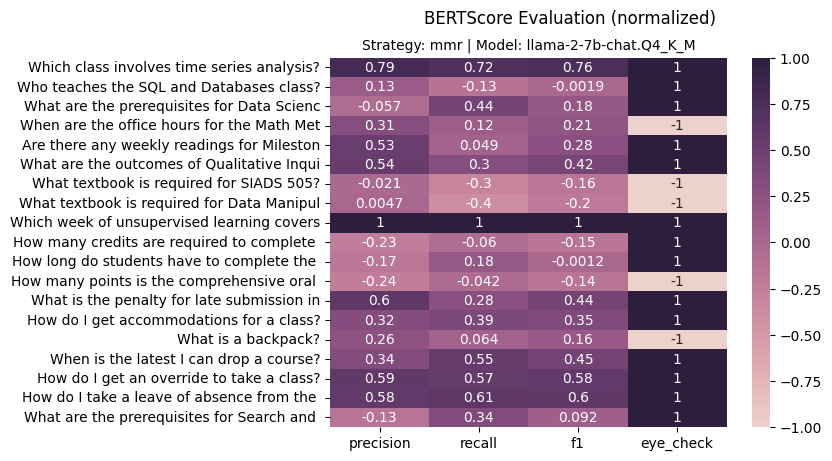

In [27]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()